<AxesSubplot:title={'center':'Ежедневная заболеваемость во времени'}, xlabel='date'>

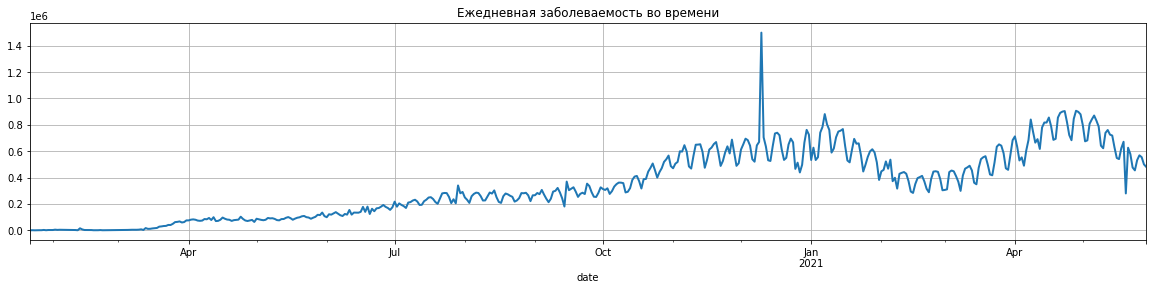

In [1]:
import pandas as pd

covid_data = pd.read_csv('data/covid_data.csv')

covid_data.head()

vaccinations_data = pd.read_csv('data/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]


'''Для объединения таблиц необходимо учитывать следующие нюансы:
1   В таблице covid_data необходимо предварительно рассчитать суммарное ежедневное число заболевших во всех провинциях/штатах в каждой стране.
2   В таблицах не совпадает число стран, а иногда и их названия. При объединении таблиц по столбцу мы определённо теряем данные (в данной задаче потери незначительны). Избежать этого можно ручными преобразованиями данных — искать различия в названиях стран в таблицах и преобразовывать их. Однако это не является темой данного модуля.
3   Таблицы имеют разные периоды наблюдений (вакцины появились позже, чем сам вирус). Объединив данные с типом inner, мы можем потерять большое количество наблюдений в таблице covid_data.
'''

covid_data = covid_data.groupby(
    ['date', 'country'], 
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum() #Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. Тем самым переходим от данных по регионам к данным по странам

covid_data['date'] = pd.to_datetime(covid_data['date']) # Преобразуем даты в формат datetime

covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']  # Создадим признак больных на данный момент (active).


covid_data = covid_data.sort_values(by=['country', 'date'])                         # Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей.  
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()   # Для этого отсортируем данные по названиям стран, а затем по датам. 
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()         # После этого произведём группировку по странам и рассчитаем разницу между «вчера и сегодня» с помощью метода diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])


vaccinations_data['date'].sort_values()

covid_data
covid_df=covid_data.merge(
    vaccinations_data,
    on=['date', 'country'],
    how='left'
)




covid_df['death_rate']=covid_df['deaths']/covid_df['confirmed']*100
covid_df['recover_rate']=covid_df['recovered']/covid_df['confirmed']*100

covid_df.to_csv('data/covid_df.csv', index=False, sep=';')

covid_df[covid_df['country']=='Russia']['recover_rate'].mean()




'''     Построение линейного графика      '''


grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind='line',    # тип визуализации. Основные типы:

                    #'line' — линейный график (по умолчанию);
                    #'bar' — столбчатая диаграмма;
                    #'barh' — горизонтальная столбчатая диаграмма;
                    #'hist' — гистограмма;
                    #'box' — коробчатая диаграмма (boxplot);
                    #'pie' — круговая диаграмма;
                    #'scatter' — диаграмма рассеяния.

    figsize=(20, 4),    # размер графика (кортеж из ширины и высоты в дюймах)
    title='Ежедневная заболеваемость во времени', # название графика
    grid = True,    # отображение сетки (по умолчанию False)
    lw=2            # жырнота линий
)


<AxesSubplot:xlabel='country'>

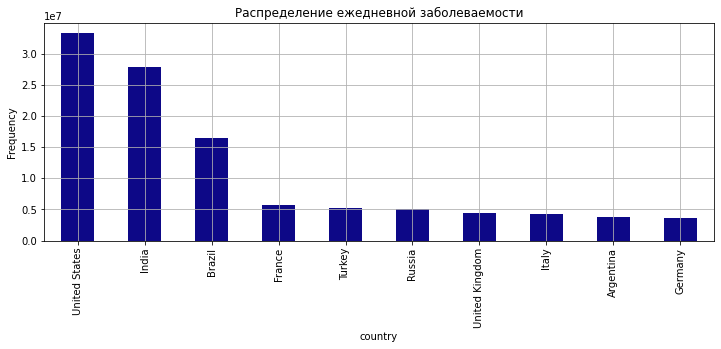

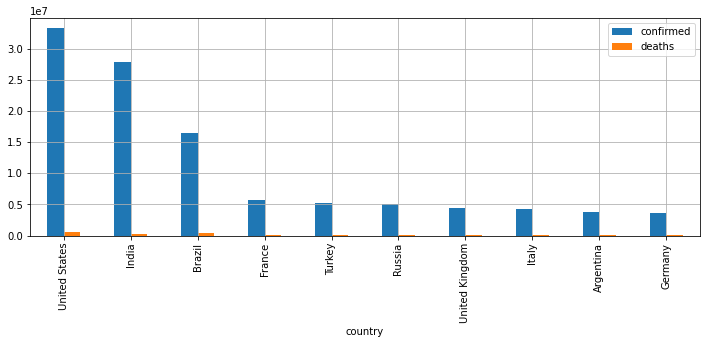

In [31]:
'''            Построение гистограммы           '''
grouped_cases.plot(
    kind='hist',
    figsize=(10, 6),
    title='Распределение ежедневной заболеваемости',
    grid = True,
    color = 'black',
    bins=10
)

'''         Построение столбчатой диаграммы         '''
grouped_country = covid_df.groupby(['country'])['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'
)


grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()

grouped_country = grouped_country.nlargest(10, columns=['confirmed'])

grouped_country.plot( 
    kind='bar', 
    grid=True, 
    figsize=(12, 4), 
)



<AxesSubplot:xlabel='country'>

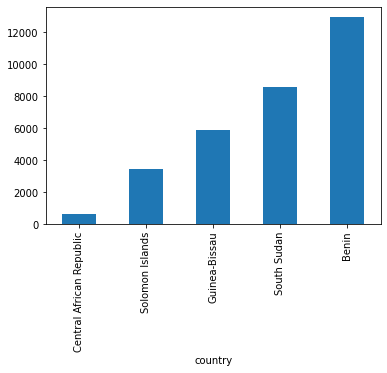

In [32]:
covid_df.groupby(['country'])['total_vaccinations'].last().nsmallest(5).plot(kind='bar')